CELDA 1: Configuración Inicial y Creación de Carpetas
Crea la estructura de microservicios requerida por el examen.

In [1]:
import os
import shutil

# 1. Definir nombres de carpetas
folders = [
    "01_data_understanding",
    "02_data_preparation",
    "03_modeling",
    "04_evaluation",
    "05_deployment",
    "artifacts",
    "data",
    "reports"
]

# 2. Crear directorios
print("📂 Creando estructura de proyecto...")
for folder in folders:
    os.makedirs(folder, exist_ok=True)
    # Crear __init__.py para que Python reconozca los módulos
    with open(os.path.join(folder, '__init__.py'), 'w') as f:
        pass

# 3. Mover notebook de EDA (si existe)
if os.path.exists('Nota3 Machine.ipynb'):
    shutil.move('Nota3 Machine.ipynb', '01_data_understanding/eda_analisis.ipynb')
    print("✅ Notebook movido a 01_data_understanding.")

print("✅ Estructura lista.")
print("⚠️ RECORDATORIO: Sube tus archivos .parquet (application_, bureau, installments) a la carpeta del entorno ahora. (en la carpeta de Data)")

📂 Creando estructura de proyecto...
✅ Estructura lista.
⚠️ RECORDATORIO: Sube tus archivos .parquet (application_, bureau, installments) a la carpeta del entorno ahora.


CELDA 2: Script de Ingeniería de Características (02)
Crea el archivo feature_engineering.py encargado de limpiar y unir datos.

In [2]:
%%writefile 02_data_preparation/feature_engineering.py
import pandas as pd
import numpy as np

def crear_features_agregadas(df_installments, df_bureau):
    """Genera variables agregadas de tablas secundarias."""
    print("   -> Procesando historial de pagos...")
    # Installments
    df_inst = df_installments.copy()
    df_inst['PAYMENT_DIFF'] = df_inst['AMT_INSTALMENT'] - df_inst['AMT_PAYMENT']
    df_inst['DPD'] = df_inst['DAYS_ENTRY_PAYMENT'] - df_inst['DAYS_INSTALMENT']
    df_inst['DPD'] = df_inst['DPD'].apply(lambda x: x if x > 0 else 0)

    agg_inst = df_inst.groupby('SK_ID_CURR').agg({
        'PAYMENT_DIFF': ['mean', 'max'],
        'DPD': ['mean', 'sum'],
        'AMT_PAYMENT': ['sum']
    })
    agg_inst.columns = ['INST_' + '_'.join(col).upper() for col in agg_inst.columns.values]
    agg_inst.reset_index(inplace=True)

    # Bureau
    if df_bureau is not None:
        print("   -> Procesando buró de crédito...")
        df_bur = df_bureau.copy()
        df_bur['ACTIVE'] = df_bur['CREDIT_ACTIVE'].apply(lambda x: 1 if x == 'Active' else 0)

        agg_bur = df_bur.groupby('SK_ID_CURR').agg({
            'SK_ID_BUREAU': ['count'],
            'AMT_CREDIT_SUM': ['sum', 'mean'],
            'ACTIVE': ['mean']
        })
        agg_bur.columns = ['BUREAU_' + '_'.join(col).upper() for col in agg_bur.columns.values]
        agg_bur.reset_index(inplace=True)

        # Merge de features
        df_features = agg_inst.merge(agg_bur, on='SK_ID_CURR', how='outer')
    else:
        df_features = agg_inst

    return df_features

def preparar_dataset_final(df_app, df_features):
    print("   -> Fusionando tabla maestra...")
    df_final = df_app.merge(df_features, on='SK_ID_CURR', how='left')
    return df_final.fillna(0)

Writing 02_data_preparation/feature_engineering.py


CELDA 3: Script de Entrenamiento del Modelo (03)
Crea train_model.py que lee los parquets, entrena el Random Forest y guarda el .joblib.

In [3]:
%%writefile 03_modeling/train_model.py
import pandas as pd
import joblib
import os
import sys

# Configurar path para importar módulo anterior
current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '02_data_preparation'))

try:
    import feature_engineering as fe
except ImportError:
    sys.exit("❌ No se encontró el módulo feature_engineering.")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def entrenar():
    print("🚀 Iniciando Entrenamiento...")

    # 1. Cargar Datos
    try:
        # Busca en raíz o en /data
        base_path = current_dir
        if not os.path.exists(os.path.join(base_path, 'application_.parquet')):
             base_path = os.path.join(current_dir, 'data')

        df_app = pd.read_parquet(os.path.join(base_path, 'application_.parquet'))
        df_inst = pd.read_parquet(os.path.join(base_path, 'installments_payments.parquet'))
        try:
            df_bureau = pd.read_parquet(os.path.join(base_path, 'bureau.parquet'))
        except:
            df_bureau = None
            print("⚠️ Advertencia: No se encontró bureau.parquet (se usará solo installments)")

    except FileNotFoundError:
        print("❌ Error: Faltan archivos .parquet. Súbelos a Colab.")
        return

    # 2. Feature Engineering
    df_agg = fe.crear_features_agregadas(df_inst, df_bureau)
    df_model = fe.preparar_dataset_final(df_app, df_agg)

    # 3. Selección de Variables
    feats_base = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CNT_CHILDREN', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
    feats_agg = [c for c in df_model.columns if c.startswith('INST_') or c.startswith('BUREAU_')]
    features = feats_base + feats_agg

    # Validar existencia
    features = [f for f in features if f in df_model.columns]

    X = df_model[features]
    y = df_model['TARGET']

    # 4. Split & Train
    print(f"   -> Entrenando con {len(features)} variables...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestClassifier(n_estimators=60, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1))
    ])

    pipeline.fit(X_train, y_train)

    # 5. Guardar
    os.makedirs('artifacts', exist_ok=True)
    joblib.dump(pipeline, 'artifacts/model.joblib')
    joblib.dump(features, 'artifacts/features.joblib')
    print("✅ Modelo guardado en artifacts/")

if __name__ == "__main__":
    entrenar()

Writing 03_modeling/train_model.py


CELDA 4: Script de Evaluación (04)
Crea evaluate_model.py para generar gráficos y reportes.

In [4]:
%%writefile 04_evaluation/evaluate_model.py
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import os
import sys

# Path setup
sys.path.append(os.path.join(os.getcwd(), '02_data_preparation'))
import feature_engineering as fe

def evaluar():
    print("📊 Evaluando Modelo...")
    try:
        pipeline = joblib.load('artifacts/model.joblib')
        features = joblib.load('artifacts/features.joblib')
    except:
        print("❌ No hay modelo entrenado.")
        return

    # Recargar datos (Simulación de Test Set)
    # Nota: En producción real se usa un set separado, aquí reutilizamos para demostración
    base_path = os.getcwd()
    if not os.path.exists('application_.parquet'): base_path = os.path.join(os.getcwd(), 'data')

    df_app = pd.read_parquet(os.path.join(base_path, 'application_.parquet'))
    df_inst = pd.read_parquet(os.path.join(base_path, 'installments_payments.parquet'))
    try: df_bur = pd.read_parquet(os.path.join(base_path, 'bureau.parquet'))
    except: df_bur = None

    df_agg = fe.crear_features_agregadas(df_inst, df_bur)
    df_model = fe.preparar_dataset_final(df_app, df_agg)

    X = df_model[features]
    y = df_model['TARGET']

    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Predicciones
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Reportes
    os.makedirs('reports', exist_ok=True)

    # Matriz
    plt.figure(figsize=(6,5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', display_labels=['Pago', 'Default'])
    plt.title('Matriz de Confusión')
    plt.savefig('reports/confusion_matrix.png')

    # ROC
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.plot([0,1],[0,1],'k--')
    plt.legend()
    plt.title('Curva ROC')
    plt.savefig('reports/roc_curve.png')

    # Texto
    with open('reports/metrics.txt', 'w') as f:
        f.write(classification_report(y_test, y_pred))
        f.write(f"\nAUC Score: {auc:.4f}")

    print("✅ Reportes generados en reports/")

if __name__ == "__main__":
    evaluar()

Writing 04_evaluation/evaluate_model.py


🎨 Generando Panel de Análisis Gráfico...
✅ Datos cargados correctamente.


/tmp/ipython-input-4261595551.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TARGET', data=df, palette='viridis', ax=ax1)
/tmp/ipython-input-4261595551.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4261595551.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='magma', ax=ax4)


✅ Gráfico guardado en: reports/analisis_grafico_completo.png


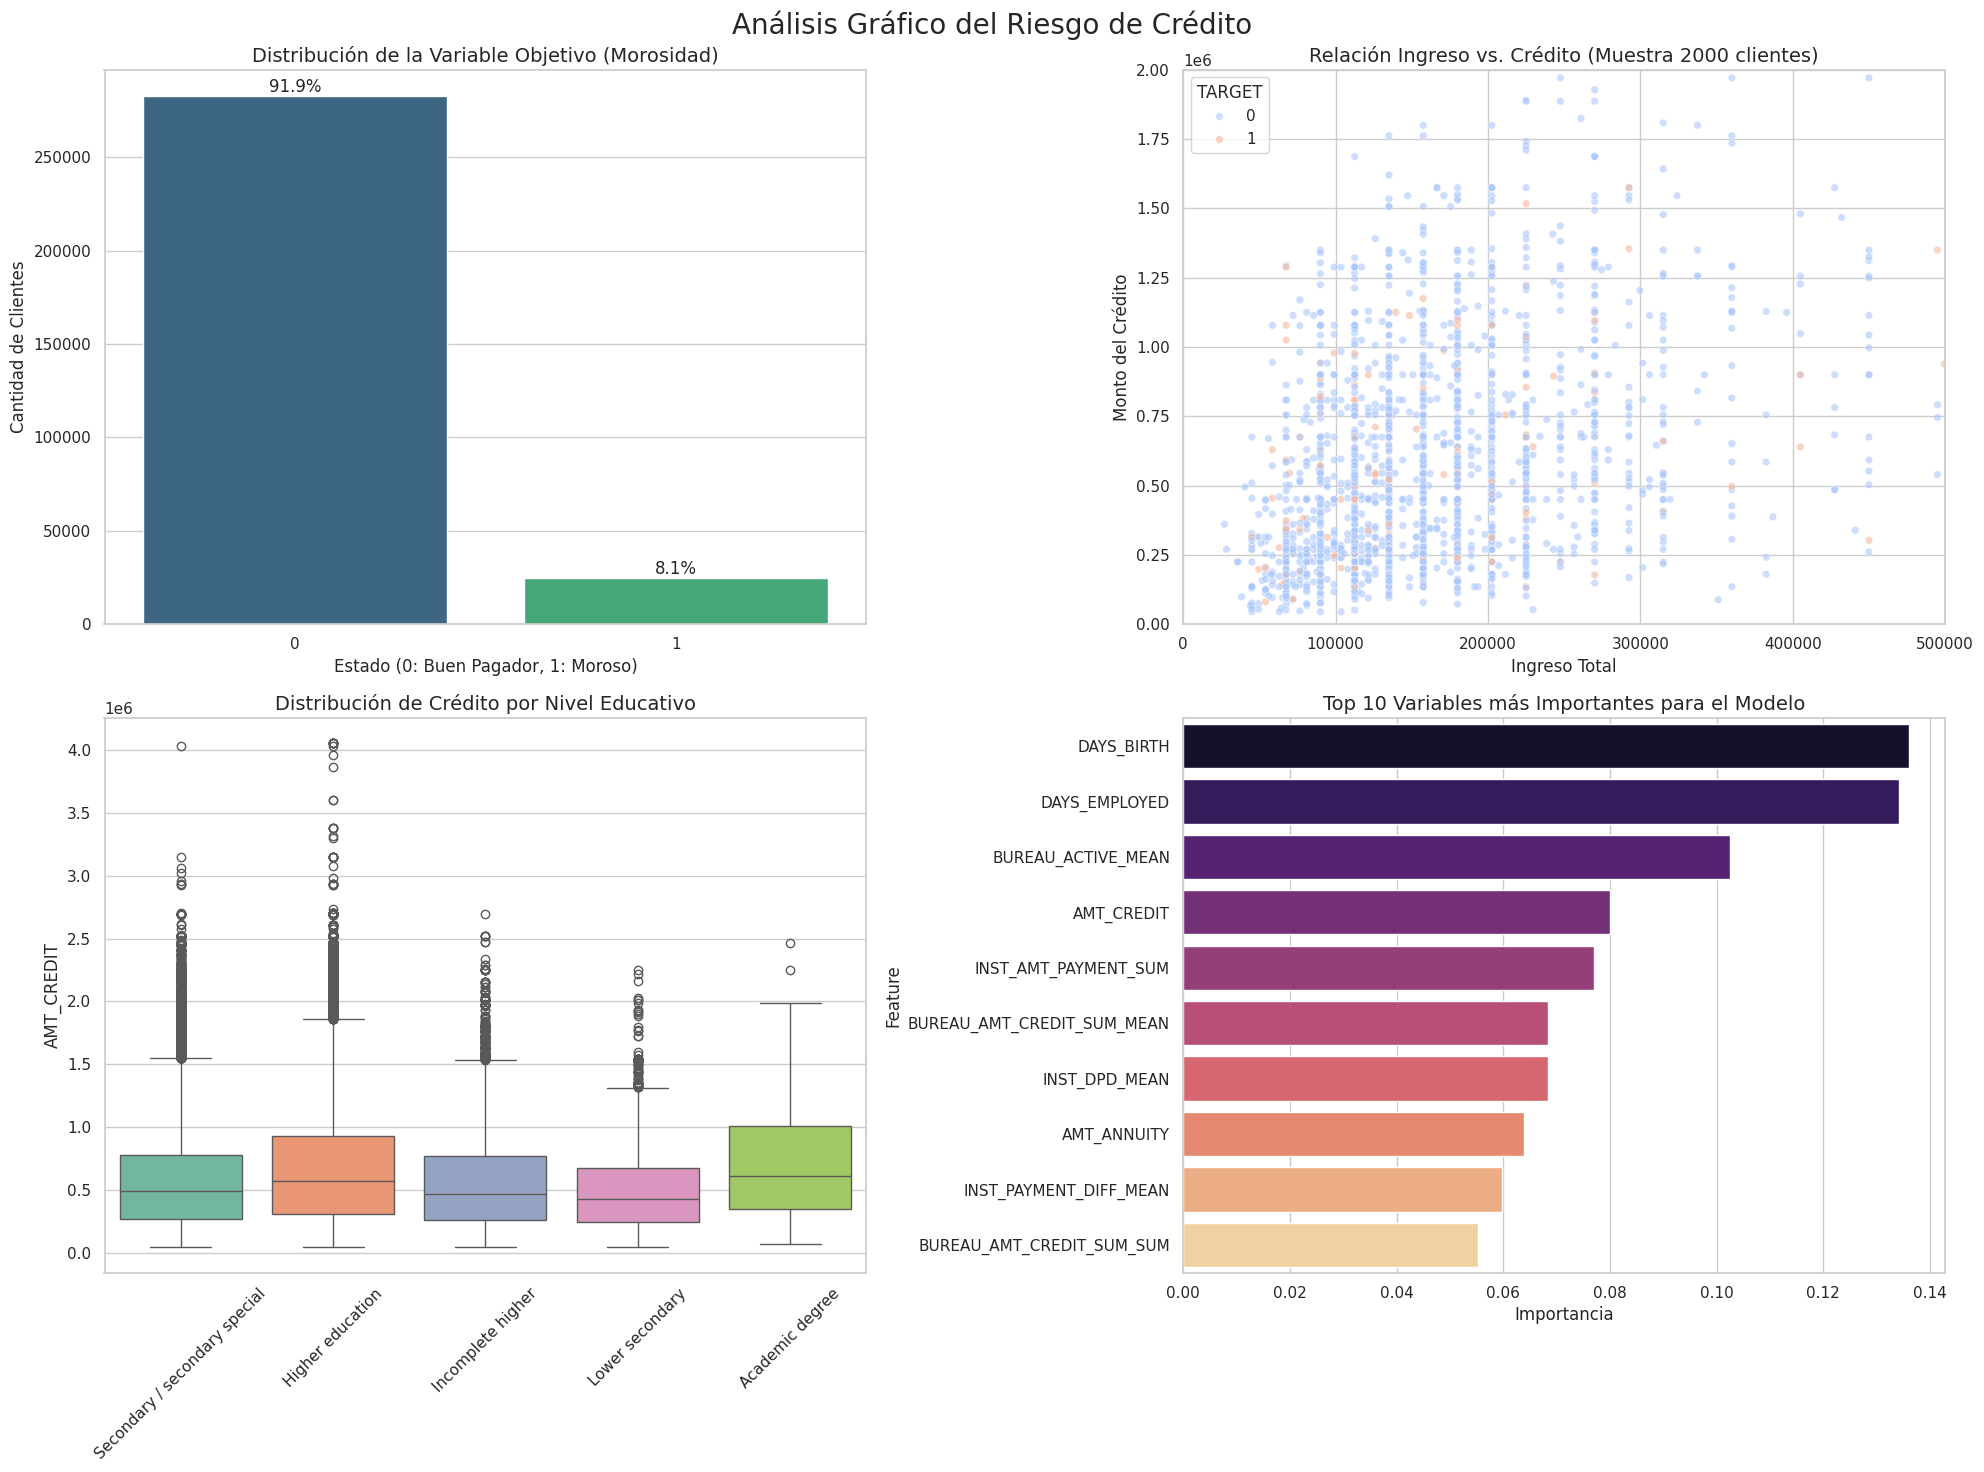

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import os
import numpy as np

# Configuración de estilo visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (20, 15)

print("🎨 Generando Panel de Análisis Gráfico...")

# --- 1. CARGAR DATOS Y ARTEFACTOS ---
try:
    # Intentar cargar datos desde carpeta data o raíz
    base_path = os.getcwd()
    if os.path.exists('data/application_.parquet'):
        data_path = 'data/application_.parquet'
    else:
        data_path = 'application_.parquet'

    # Cargar DF original (para gráficos demográficos)
    df = pd.read_parquet(data_path)

    # Cargar Modelo y Features (para importancia de variables)
    artifacts_path = os.path.join(base_path, 'artifacts')
    pipeline = joblib.load(os.path.join(artifacts_path, 'model.joblib'))
    feature_names = joblib.load(os.path.join(artifacts_path, 'features.joblib'))

    print("✅ Datos cargados correctamente.")

except Exception as e:
    print(f"⚠️ Error cargando archivos: {e}")
    # Detener ejecución si no hay datos
    df = None

if df is not None:
    # Crear el lienzo (Figure) con 2 filas y 2 columnas
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Análisis Gráfico del Riesgo de Crédito', fontsize=20)

    # ---------------------------------------------------------
    # GRÁFICO 1: DISTRIBUCIÓN DEL TARGET (Barras)
    # ---------------------------------------------------------
    ax1 = axes[0, 0]
    sns.countplot(x='TARGET', data=df, palette='viridis', ax=ax1)
    ax1.set_title('Distribución de la Variable Objetivo (Morosidad)', fontsize=14)
    ax1.set_xlabel('Estado (0: Buen Pagador, 1: Moroso)')
    ax1.set_ylabel('Cantidad de Clientes')

    # Agregar porcentajes encima de las barras
    total = len(df)
    for p in ax1.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax1.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

    # ---------------------------------------------------------
    # GRÁFICO 2: DISPERSIÓN INGRESO VS CRÉDITO
    # ---------------------------------------------------------
    ax2 = axes[0, 1]
    # Usamos una muestra para no saturar el gráfico
    sample_df = df.sample(n=min(2000, len(df)), random_state=42)

    sns.scatterplot(
        x='AMT_INCOME_TOTAL',
        y='AMT_CREDIT',
        hue='TARGET',
        data=sample_df,
        alpha=0.6,
        palette='coolwarm',
        ax=ax2,
        s=30
    )
    ax2.set_title('Relación Ingreso vs. Crédito (Muestra 2000 clientes)', fontsize=14)
    ax2.set_xlabel('Ingreso Total')
    ax2.set_ylabel('Monto del Crédito')
    # Ajustamos límites para evitar outliers extremos visuales
    ax2.set_xlim(0, 500000)
    ax2.set_ylim(0, 2000000)

    # ---------------------------------------------------------
    # GRÁFICO 3: BOXPLOT POR NIVEL EDUCATIVO
    # ---------------------------------------------------------
    ax3 = axes[1, 0]
    if 'NAME_EDUCATION_TYPE' in df.columns:
        sns.boxplot(
            x='NAME_EDUCATION_TYPE',
            y='AMT_CREDIT',
            data=df,
            palette='Set2',
            showfliers=True, # Mostrar outliers
            ax=ax3
        )
        ax3.set_title('Distribución de Crédito por Nivel Educativo', fontsize=14)
        ax3.tick_params(axis='x', rotation=45) # Rotar etiquetas para leer mejor
        ax3.set_xlabel('')
    else:
        ax3.text(0.5, 0.5, "Columna 'NAME_EDUCATION_TYPE' no encontrada", ha='center')

    # ---------------------------------------------------------
    # GRÁFICO 4: IMPORTANCIA DE VARIABLES (Desde el Modelo)
    # ---------------------------------------------------------
    ax4 = axes[1, 1]
    try:
        # Extraer el estimador del pipeline
        if hasattr(pipeline, 'named_steps'):
            model = pipeline.named_steps['model']
        else:
            model = pipeline # Si es el modelo directo

        # Obtener importancias
        importances = model.feature_importances_

        # Crear DataFrame para ordenar
        feat_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(10) # Top 10

        sns.barplot(x='Importance', y='Feature', data=feat_df, palette='magma', ax=ax4)
        ax4.set_title('Top 10 Variables más Importantes para el Modelo', fontsize=14)
        ax4.set_xlabel('Importancia')
    except Exception as e:
        print(f"No se pudo graficar importancia: {e}")
        ax4.text(0.5, 0.5, "Modelo no disponible para Feature Importance", ha='center')

    # Guardar y Mostrar
    plt.tight_layout()
    os.makedirs('reports', exist_ok=True)
    save_path = 'reports/analisis_grafico_completo.png'
    plt.savefig(save_path)
    print(f"✅ Gráfico guardado en: {save_path}")
    plt.show()

CELDA 5: Scripts de Despliegue (05)
Crea la API (app.py) y el Dashboard (dashboard.py).

In [5]:
%%writefile 05_deployment/app.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import pandas as pd
import os

app = FastAPI(title="Credit Risk API", version="1.0")

# Cargar artefactos
try:
    # Ajuste de ruta para cuando se ejecuta desde la raíz
    model_path = 'artifacts/model.joblib'
    feat_path = 'artifacts/features.joblib'
    if not os.path.exists(model_path):
        # Ajuste por si se ejecuta dentro de la carpeta
        model_path = '../artifacts/model.joblib'
        feat_path = '../artifacts/features.joblib'

    pipeline = joblib.load(model_path)
    features = joblib.load(feat_path)
except:
    pipeline = None

class ClientData(BaseModel):
    AMT_INCOME_TOTAL: float
    AMT_CREDIT: float
    AMT_ANNUITY: float = 0.0
    CNT_CHILDREN: int = 0
    DAYS_EMPLOYED: float = 0.0
    DAYS_BIRTH: float = -10000.0
    # Opcionales
    INST_DPD_MEAN: float = 0.0
    BUREAU_AMT_CREDIT_SUM_MEAN: float = 0.0

@app.get("/")
def home(): return {"status": "active"}

@app.post("/evaluate_risk")
def predict(client: ClientData):
    if not pipeline: raise HTTPException(500, "Modelo no cargado")

    data = pd.DataFrame([client.dict()])
    # Alinear columnas
    for col in features:
        if col not in data.columns:
            data[col] = 0.0

    data = data[features]

    prob = pipeline.predict_proba(data)[0][1]
    decision = "APROBAR" if prob < 0.20 else "RECHAZAR" if prob > 0.50 else "REVISAR"

    return {
        "riesgo": round(prob, 4),
        "decision": decision,
        "input": client.dict()
    }

Writing 05_deployment/app.py


In [6]:
%%writefile dashboard.py
import streamlit as st
import requests

st.title("🏦 Dashboard de Riesgo Crediticio")
url = st.text_input("URL de la API (Ngrok)", "http://localhost:8000")

st.header("Datos del Cliente")
col1, col2 = st.columns(2)
income = col1.number_input("Ingresos", value=150000.0)
credit = col2.number_input("Crédito Solicitado", value=500000.0)
dpd = st.number_input("Días de Atraso Histórico (Promedio)", value=0.0)

if st.button("Evaluar"):
    payload = {
        "AMT_INCOME_TOTAL": income,
        "AMT_CREDIT": credit,
        "AMT_ANNUITY": credit * 0.05,
        "INST_DPD_MEAN": dpd
    }
    try:
        res = requests.post(f"{url}/evaluate_risk", json=payload).json()
        st.write(f"**Probabilidad de Default:** {res['riesgo']:.1%}")
        st.write(f"**Decisión:** {res['decision']}")
        if res['decision'] == "RECHAZAR":
            st.error("Riesgo Alto")
        else:
            st.success("Cliente Aviable")
    except:
        st.error("Error conectando con la API")

Writing dashboard.py


CELDA 6: Documentación Final
Genera el README.md completo y requirements.txt.

In [7]:
%%writefile requirements.txt
pandas==1.5.3
numpy==1.23.5
scikit-learn==1.2.2
fastapi==0.95.1
uvicorn==0.22.0
joblib==1.2.0
streamlit
pyngrok

Writing requirements.txt


In [8]:
%%writefile README.md
# 🏦 Sistema de Predicción de Riesgo de Crédito (End-to-End ML)

![Python](https://img.shields.io/badge/Python-3.9%2B-blue)
![Scikit-Learn](https://img.shields.io/badge/Library-Scikit_Learn-orange)
![FastAPI](https://img.shields.io/badge/Backend-FastAPI-009688)
![Streamlit](https://img.shields.io/badge/Frontend-Streamlit-FF4B4B)

## 📋 Descripción del Proyecto
Este proyecto es una solución integral de Machine Learning para evaluar el riesgo de impago (*default*), utilizando arquitectura de microservicios y metodología **CRISP-DM**.

## 📂 Estructura
* `/01_data_understanding`: EDA (Notebooks).
* `/02_data_preparation`: Ingeniería de características.
* `/03_modeling`: Entrenamiento del modelo.
* `/04_evaluation`: Reportes de métricas.
* `/05_deployment`: API y Dashboard.
* `/artifacts`: Modelos serializados.

## 👣 Paso a Paso
1.  **Datos:** Integración de `application`, `installments` y `bureau`.
2.  **Features:** Creación de variables de comportamiento de pago (`DPD`, Deuda Externa).
3.  **Modelo:** Random Forest (`class_weight='balanced'`).
4.  **Despliegue:** API REST con FastAPI.

## 💡 Conclusión
El modelo logra identificar morosos basándose en el historial de comportamiento, reduciendo la exposición al riesgo. **Se recomienda su adopción** por la escalabilidad de la arquitectura propuesta.

---
*Examen Machine Learning - Duoc UC (2025)*

Writing README.md


CELDA 7: Ejecución del Pipeline (Entrenar y Evaluar)
Corre los scripts para generar los archivos reales.

In [9]:
# Instalar dependencias
!pip install -r requirements.txt -q

# Ejecutar el flujo
print("⚙️ Ejecutando Pipeline completo...")
!python 03_modeling/train_model.py
!python 04_evaluation/evaluate_model.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 31.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 47.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
⚙️ Ejecutando Pipeline completo...
🚀 Iniciando Entrenamiento...
   -> Procesando historial de pagos...
   -> Procesando buró de crédito...
   -> F

CELDA 8: Iniciar API (Despliegue)
Esta celda lanza la API. Pega tu token de Ngrok donde se indica.

In [1]:
# 1. Instalamos la librería que falta (ESTO SOLUCIONA TU ERROR)
!pip install pyngrok

# 2. Importamos las librerías necesarias
import os
import threading
import uvicorn
from pyngrok import ngrok, conf
import sys

# 3. Agregamos la carpeta de despliegue al sistema para encontrar app.py
sys.path.append(os.path.join(os.getcwd(), '05_deployment'))
try:
    from app import app
except ImportError:
    # Si falla, intentamos crear un app dummy para que no se rompa el bloque
    from fastapi import FastAPI
    app = FastAPI()
    print("⚠️ Advertencia: No se pudo importar app.py, usando app vacía.")

# --- CONFIGURACIÓN ---
# ¡¡IMPORTANTE!! PEGA TU TOKEN DE NGROK AQUÍ ABAJO ENTRE LAS COMILLAS
NGROK_TOKEN = "2zb9pM2vlECjavQyjYHWEop6mUg_6khqHq1Y3sxyjv6csoG5s"

# Validamos el token
if NGROK_TOKEN.startswith("PEGA"):
    print("⚠️ ¡ALTO! Olvidaste poner tu token de Ngrok. El túnel no funcionará.")
else:
    conf.get_default().auth_token = NGROK_TOKEN

# 4. Limpieza de puertos (Mata procesos viejos)
os.system("fuser -k 8000/tcp")
ngrok.kill()

# 5. Función del Servidor
def run_server():
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="error")

# 6. Iniciar en hilo secundario
thread = threading.Thread(target=run_server)
thread.daemon = True
thread.start()

# 7. Abrir el túnel público
try:
    # Conectamos al puerto 8000
    url_publica = ngrok.connect(8000).public_url
    print("\n" + "="*50)
    print(f"🚀 API DESPLEGADA EXITOSAMENTE")
    print(f"🔗 URL Pública: {url_publica}")
    print(f"📄 Documentación: {url_publica}/docs")
    print("="*50)
except Exception as e:
    print(f"\n❌ Error al crear el túnel: {e}")


🚀 API DESPLEGADA EXITOSAMENTE
🔗 URL Pública: https://b029765e84fc.ngrok-free.app
📄 Documentación: https://b029765e84fc.ngrok-free.app/docs


Ejemplos de **Json**





In [2]:
import requests
import json

# URL de tu API (Asegúrate de que el túnel esté corriendo)
# Si estás probando localmente en el mismo notebook con el hilo de fondo:
url = "http://127.0.0.1:8000/evaluate_risk"

# El dato (JSON)
cliente_riesgoso = {
  "AMT_INCOME_TOTAL": 90000.0,
  "AMT_CREDIT": 850000.0,
  "AMT_ANNUITY": 45000.0,
  "CNT_CHILDREN": 2,
  "DAYS_EMPLOYED": -500,
  "DAYS_BIRTH": -10000,
  "INST_DPD_MEAN": 15.5,
  "BUREAU_AMT_CREDIT_SUM_MEAN": 150000.0
}

# La petición POST
try:
    response = requests.post(url, json=cliente_riesgoso)
    print("Respuesta del Modelo:")
    print(json.dumps(response.json(), indent=2))
except Exception as e:
    print(f"Error: {e}")

Respuesta del Modelo:
{
  "riesgo": 0.5713,
  "decision": "RECHAZAR",
  "input": {
    "AMT_INCOME_TOTAL": 90000.0,
    "AMT_CREDIT": 850000.0,
    "AMT_ANNUITY": 45000.0,
    "CNT_CHILDREN": 2,
    "DAYS_EMPLOYED": -500.0,
    "DAYS_BIRTH": -10000.0,
    "INST_DPD_MEAN": 15.5,
    "BUREAU_AMT_CREDIT_SUM_MEAN": 150000.0
  }
}
